In [1]:
##### Libraries #####
import dotenv
dotenv.load_dotenv(".env")
import os
import time
import utils
import shutil
import argparse
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)
import models_tensorflow.EEGModels
from typing import Literal
from tensorflow.keras import backend
from tensorflow.keras import utils as tf_utils
backend.set_image_data_format("channels_last")
from sklearn.model_selection import train_test_split

import utils
from utils import Metric, plot_confusion_matrix, plot_history
from libs.dataset import BcicIv2aDataset, InnerSpeechDataset

## Load BCIC IV 2a Dataset 

In [2]:
os.environ["DATASET_DIR"] = 'datasets'

In [3]:
dataset = BcicIv2aDataset()  # l_freq=4
inputs, truths = dataset.all_data_and_label

Loading BCIC IV 2a dataset - A09E: 100%|████████| 18/18 [00:23<00:00,  1.28s/it]


In [4]:
print(inputs.shape)
print(truths.shape)

(5184, 22, 257)

## Prepare Inputs and Ground Truth Data

### Converting inputs to shape (batch_size, sequence_length, num_features)

In [7]:
inputs = np.transpose(inputs, (0, 2, 1))
print(inputs.shape)

(5184, 257, 22)


In [8]:
# Example function to load dataset (this should be replaced with actual data loading)
def load_dataset():
    x =  inputs #  np.random.rand(100, 22, 257)  # Simulated input data
    y =  inputs # np.random.rand(100, 22, 257)  # Simulated ground truth data
    return x, y


In [9]:
inputs, truths = load_dataset()

In [1]:
print(inputs.shape)
print(truths.shape)

NameError: name 'inputs' is not defined

### Currupt inputs to pose reconstruction problem:

In [11]:
import numpy as np

def add_gaussian_noise(data, noise_level=0.01):
    """
    Adds Gaussian noise to the EEG data.

    Parameters:
    - data: numpy array of shape (batch_size, sequence_length, num_features), the original EEG data.
    - noise_level: float, standard deviation of the Gaussian noise relative to the data's standard deviation.

    Returns:
    - noisy_data: numpy array of the same shape as 'data', original data with Gaussian noise added.
    """
    # Calculate the standard deviation of the original data
    data_std = np.std(data)

    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_level * data_std, size=data.shape)

    # Add noise to the original data
    noisy_data = data + noise

    return noisy_data


In [12]:
noise_level = 0.1  # Adjust the noise level according to your need
noisy_inputs = add_gaussian_noise(inputs, noise_level=noise_level)

In [13]:
noisy_inputs.shape

(5184, 257, 22)

In [14]:
import matplotlib.pyplot as plt

def plot_eeg_time_series(original_data, noisy_data, denoised_data=None, channel_indices=[0], time_range=None):
    """
    Plots EEG time series for specified channels and time ranges with data shaped as (batch_size, sequence_length, num_features).

    Parameters:
    - original_data: numpy array of shape (samples, sequence_length, channels), original EEG data.
    - noisy_data: numpy array of the same shape, noisy EEG data.
    - denoised_data: numpy array of the same shape as original_data, denoised EEG data (optional).
    - channel_indices: list of int, indices of the channels to plot.
    - time_range: tuple of (start, end), range of time steps to plot.
    """
    # Define time range to plot if not specified
    if time_range is None:
        time_range = (0, original_data.shape[1])  # Plot all time steps
    
    num_plots = len(channel_indices)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 3 * num_plots), squeeze=False)
    
    # Iterate over each channel to plot
    for i, channel_idx in enumerate(channel_indices):
        ax = axes[i][0]
        # Plot the original, noisy, and denoised data for each channel
        ax.plot(original_data[0, time_range[0]:time_range[1], channel_idx], label='Original', color='blue')
        ax.plot(noisy_data[0, time_range[0]:time_range[1], channel_idx], label='Noisy', color='red')
        if denoised_data is not None:
            ax.plot(denoised_data[0, time_range[0]:time_range[1], channel_idx], label='Denoised', color='green')
        
        ax.set_title(f'Channel {channel_idx + 1}')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Amplitude')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


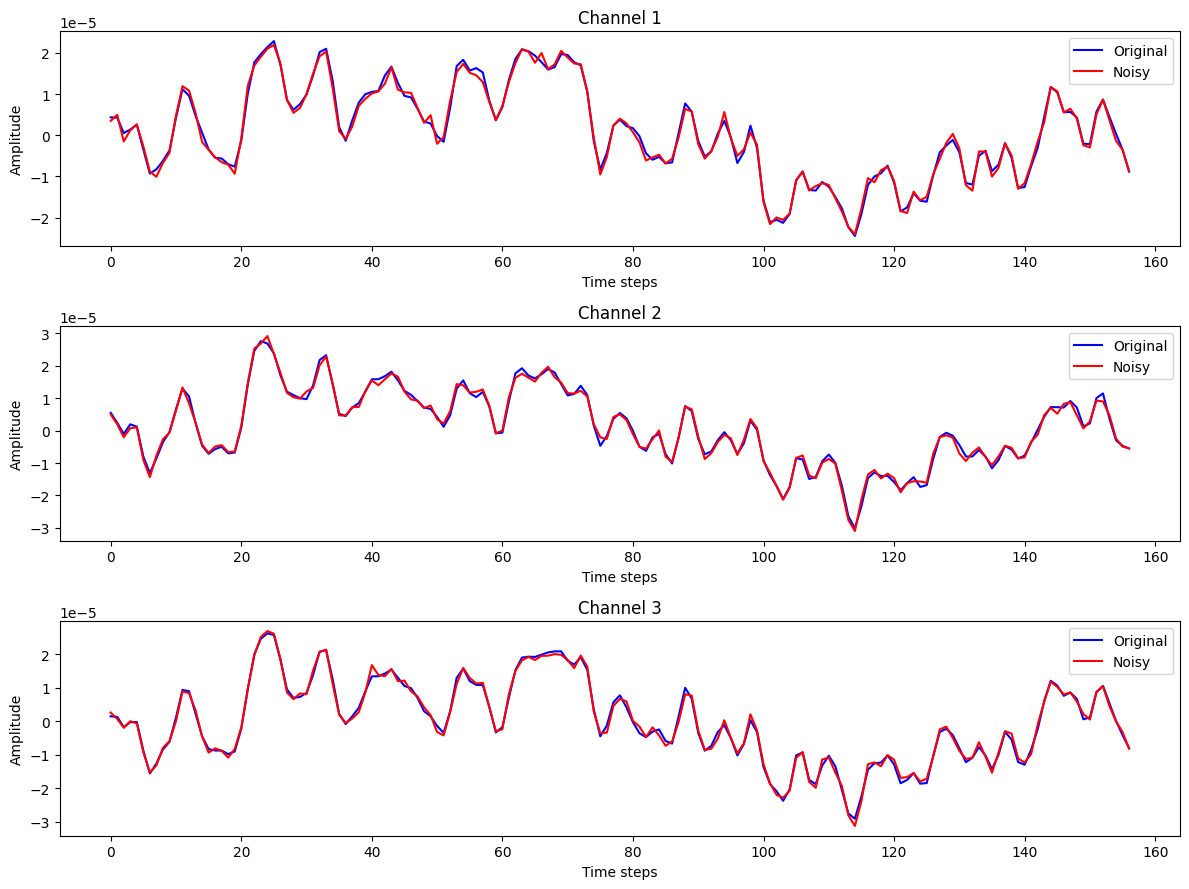

In [15]:
# Example usage:
# Assuming 'inputs', 'noisy_inputs', and 'denoised_outputs' are available
plot_eeg_time_series(inputs, noisy_inputs, denoised_data=None, channel_indices=[0, 1, 2], time_range=(100, 300))


In [17]:
# Normalize data to range [0, 1] for consistency
noisy_inputs = (noisy_inputs - np.min(noisy_inputs)) / (np.max(noisy_inputs) - np.min(noisy_inputs))
truths = (truths - np.min(truths)) / (np.max(truths) - np.min(truths))

In [18]:
# Split the data into training and testing sets to evaluate model performance
x_train, x_test, y_train, y_test = train_test_split(noisy_inputs, truths, test_size=0.2, random_state=42)


In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(4147, 257, 22)
(4147, 257, 22)
(1037, 257, 22)
(1037, 257, 22)


## Build Transformer Autoencoder Model

In [23]:
# conda install -c conda-forge torch -y
# !conda install pytorch torchvision torchaudio -c pytorch-nightly -y

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import matplotlib.pyplot as plt
import numpy as np
import copy

In [25]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [26]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)# positional encoding vector
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # Add the positional encodings to the input tensor
        x = x + self.pe[:, :x.size(1)]
        return x

# Each row of the "pe" vector represents a position (or time step) within the sequence.
# Each column of the "pe" vector represents a dimension in the positional encoding space.
# The values within the "pe" vector are calculated based on the position (time step) and are \
# determined by the chosen encoding function (commonly using sine and cosine functions).

# # Example usage:
# seq_length = 10
# d_model = 16
# pos_encodings = PositionalEncoding(seq_length, d_model)
# input_data_with_pos_encodings = pos_encoder(input_data)

In [30]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
       # d_model is the dimension of the input and output vectors(layers),
       # d_ff is the dimension of the intermediate vector hidden layer
       # in the feedforward network.
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        # input tensor x, which represents the output of the self-attention
        # mechanism for a sequence of tokens.
        return self.fc2(self.relu(self.fc1(x)))

In [31]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # d_k is the dimension of each head
        
        # weight matrices W_q, W_k, and W_v are used to project\
        #  Q, K, and V into d_model-dimensional space
        self.W_q = nn.Linear(d_model, d_model) # W_q is the linear layer for Q
        self.W_k = nn.Linear(d_model, d_model) # W_k is the linear layer for K
        self.W_v = nn.Linear(d_model, d_model) # W_v is the linear layer for V
        self.W_o = nn.Linear(d_model, d_model) # W_o is the linear layer for output
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """_summary_

            The -2 and -1 indices indicate that we want to swap the last two dimensions of the tensor K.
            This effectively changes the shape of K from (batch_size, num_heads, seq_length, d_k) to
            (batch_size, num_heads, d_k, seq_length).
            This shape is suitable for matrix multiplication with Q,  as it aligns the dimensions
            for the dot product.
        """
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # These scores represent the strength of\
        # attention from each query to each key.
        if mask is not None:
        # """_summary_
        # If a mask is provided, this line masks certain values in the attention scores.\
        # The purpose of this masking is to exclude positions in the input sequence \
        # that should not receive attention. Typically, a mask has zeros at positions \
        # that should be masked and ones elsewhere. By setting the masked values to\
        # a very negative number (-1e9 in this case), it effectively makes \
        # them have negligible influence on the softmax operation.
        # """
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1) # It uses the softmax function to convert \
        #the attention scores into a probability distribution.
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # The purpose of this code is to prepare the query, key, and value tensors for \
        # multi-head attention. In multi-head attention, the input tensors are linearly \
        # transformed separately for each attention head to capture different aspects of the data. \
        # The splitting of these transformed tensors into heads allows the model to focus on\
        #  different parts of the input sequence simultaneously, which is a key feature of the Transformer architecture.

        # This code snippet applies linear transformations to the input tensors Q, K, and V \
        # and then splits the transformed tensors into multiple heads to facilitate multi-head \
        # attention computations later in the forward pass of the neural network.

        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [32]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # Step 1: Self-Attention
        attn_output = self.self_attn(x, x, x, mask)
        # Step 2: Residual Connection and Layer Normalization
        x = self.norm1(x + self.dropout(attn_output))
        # Step 3: Position-Wise Feedforward Network
        ff_output = self.feed_forward(x)
        # Step 4: Residual Connection and Layer Normalization
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [33]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [34]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

Config File

- **Number of Encoder and Decoder Layers (num_layers)** determines how deep the model is by specifying the number of stacked layers.
- **Number of Attention Heads (k)** controls the diversity and granularity of attention within each layer.
- **Model Dimensionality (d_model)** defines the dimensionality of embeddings and hidden states, impacting the model’s representational capacity.
- **Dimension of the Feedforward Network (d_ff )** controls the dimensionality of the intermediate representations in the position-wise feedforward network.


In [37]:
# !conda install -c conda-forge python-box -y

In [38]:
from box import Box
# MSL Train
config={}
config['lr']=1e-4
config['num_epochs']=3
config['k']=3 #heads
config['num_layers']=3 #of encoders and decoders in the transformer
config['win_size']=100
config['input_c']=55
config['output_c']=55 
config['d_ff']=55 # dimension of the feedforward network
config['batch_size']=256
config['dropout']=0.1
config['d_model']=512 # the size of the hidden state vectors
config['pretrained_model']=None
config['dataset']='MSL'
config['mode']='train'
config['data_path']='./dataset/MSL'
config['model_save_path']= 'checkpoints'
config['anormly_ratio']=1
config = Box(config)

In [42]:
transformer= Transformer(config.input_c,config.output_c,config.d_model,config.k, config.num_layers, config.d_ff, config.win_size, config.dropout)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


In [53]:
x_train.shape

(4147, 257, 22)

In [54]:
src_data = torch.from_numpy(x_train) 
tgt_data = torch.from_numpy(y_train) 


In [55]:
transformer.train()
loss_vals=  []
for epoch in range(10):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, config.output_c), tgt_data[:, 1:].contiguous().view(-1))
    loss_vals.append(loss.item())
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

RuntimeError: The size of tensor a (22) must match the size of tensor b (256) at non-singleton dimension 4

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization 1
    x = LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-head attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    # Skip connection
    x = x + inputs
    # Layer normalization 2
    x = LayerNormalization(epsilon=1e-6)(x)
    # Feed-forward
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    # Dropout and skip connection
    x = Dropout(dropout)(x_ff) + x
    return x

input_shape = x_train.shape[1:]  # (257, 22)
inputs = Input(shape=input_shape)
x = inputs

# Transformer block
head_size = 64
num_heads = 4
ff_dim = 256
x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout=0.1)

# Output layer
outputs = Dense(input_shape[-1], activation='linear')(x)

# Define the model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 257, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 257, 22)   │         44 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 257, 22)   │     23,318 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 257, 22)   │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 257, 256)  │      5,888 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 257, 22)   │      5,654 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 257, 22)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 257, 22)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 257, 22)   │        506 │ add_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,454 (138.49 KB)

 Trainable params: 35,454 (138.49 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.2033 - val_loss: 0.0037
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 0.0017 - val_loss: 0.0016


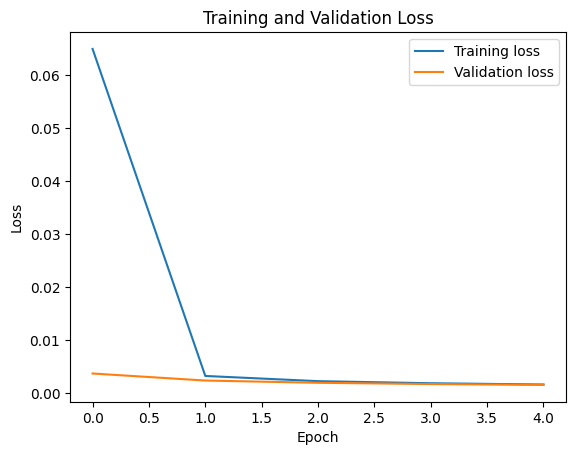

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [66]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, add
from tensorflow.keras.models import Model

def transformer_encoder_layer(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Attention and normalization
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = add([attention_output, inputs])  # Skip connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed forward network and normalization
    ffn_output = Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = add([ffn_output, attention_output])  # Skip connection
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
    
    return ffn_output


In [67]:
def build_transformer_model(input_shape, num_layers, head_size, num_heads, ff_dim, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs

    # Stack multiple layers of the Transformer encoder
    for _ in range(num_layers):
        x = transformer_encoder_layer(x, head_size, num_heads, ff_dim, dropout_rate)

    # Output layer for reconstructing the input sequence
    outputs = Dense(input_shape[-1], activation='linear')(x)

    # Create and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Model parameters
input_shape = x_train.shape[1:]  # Assuming x_train is already defined
num_layers = 3  # Number of Transformer layers
head_size = 64
num_heads = 4
ff_dim = 256

# Build the model
model = build_transformer_model(input_shape, num_layers, head_size, num_heads, ff_dim)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 257, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 257, 22)   │     23,318 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 257, 22)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 257, 22)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 257, 256)  │      5,888 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 257, 22)   │      5,654 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 257, 22)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 257, 22)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 257, 22)   │     23,318 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 257, 22)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 257, 22)   │          0 │ dropout_6[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 257, 256)  │      5,888 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 257, 22)   │      5,654 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 257, 22)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 257, 22)   │          0 │ dropout_7[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 105,350 (411.52 KB)

 Trainable params: 105,350 (411.52 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 273ms/step - loss: 0.0225 - val_loss: 0.0023
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 271ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 278ms/step - loss: 0.0022 - val_loss: 0.0019


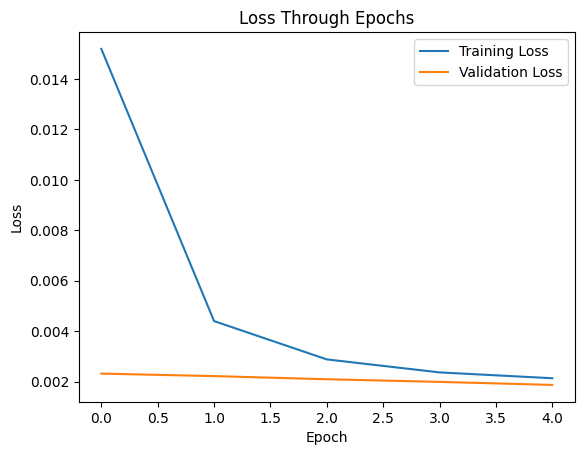

In [71]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Through Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# plot loss
my_plot(np.linspace(1, 10, 10).astype(int), loss_vals)

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape.

In [21]:
import keras
from keras import layers

In [59]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=1,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=22, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 257, 32)        │         4,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 257, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 257, 16)        │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_36             │ (None, 257, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 257, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_37             │ (None, 257, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_38             │ (None, 257, 22)        │         4,950 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,934 (73.96 KB)

 Trainable params: 18,934 (73.96 KB)

 Non-trainable params: 0 (0.00 B)

## Train CNN Autoencoder Model

In [60]:
x_train.shape

(4147, 257, 22)

In [61]:
y_train.shape

(4147, 257, 22)

In [62]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[
        # keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0610 - val_loss: 0.0023
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.8026e-04 - val_loss: 0.0015
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8616e-04 - val_loss: 0.0021
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2741e-04 - val_loss: 0.0024
Epoch 9/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0178e-04 - val_loss: 0.0021
Epoch 10/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4351e-04 - val_loss: 0.0018
Epoch 11/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9243e-04 - val_loss: 0.0016
Epoch 12/20
130/130 ━━━━━━━━

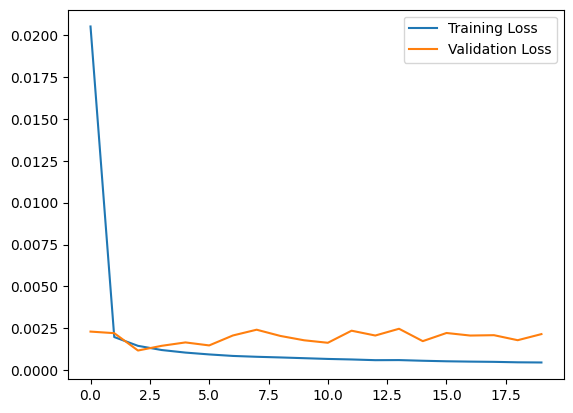

In [63]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Inference on test set

In [72]:
# Assuming 'model' is the trained Transformer model and 'x_test' is the test dataset

# Predict the outputs for the test set
predicted_outputs = model.predict(x_test)

# You can now use 'predicted_outputs' for further analysis, visualization, or post-processing
# For example, printing the shape of the outputs and some sample data
print("Shape of the predicted outputs:", predicted_outputs.shape)
# print("Sample predictions:", predicted_outputs[:5])

# If you need to compare these predictions with the actual labels
# Assuming 'y_test' contains the true values for the test set
# print("Actual true outputs:", y_train[:5])

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
Shape of the predicted outputs: (1037, 257, 22)


In [73]:


# # calculate the performance metrics, 'Mean Squared Error'
from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(y_train, predicted_outputs)
# print("Mean Squared Error on Test Set:", mse)


In [74]:
# Calculate MSE for each feature and average over all time steps
mse_per_feature = np.mean([mean_squared_error(y_test[:, i, :], predicted_outputs[:, i, :]) for i in range(y_test.shape[1])])
print("Mean Squared Error per feature, averaged over time steps:", mse_per_feature)

Mean Squared Error per feature, averaged over time steps: 0.0018677307002617776


In [75]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize a list or numpy array to store the MSE values for each channel
mse_per_channel = np.zeros((y_test.shape[1],))  # y_train.shape[1] should be 22 if there are 22 channels

# Loop through each channel and calculate MSE
for channel_index in range(y_test.shape[1]):
    # Extract the channel data for both true and predicted values
    true_channel_data = y_test[:, channel_index, :]
    predicted_channel_data = predicted_outputs[:, channel_index, :]

    # Compute the MSE for this channel
    mse_per_channel[channel_index] = mean_squared_error(true_channel_data, predicted_channel_data)

    # Optionally, print the MSE for each channel
    print(f"MSE for Channel {channel_index + 1}: {mse_per_channel[channel_index]}")


MSE for Channel 1: 0.0019649402813403188
MSE for Channel 2: 0.001865436905611269
MSE for Channel 3: 0.001890973355581295
MSE for Channel 4: 0.001988120816499351
MSE for Channel 5: 0.0020374343588883087
MSE for Channel 6: 0.002102777864656915
MSE for Channel 7: 0.0021079397959083072
MSE for Channel 8: 0.0020652430207144645
MSE for Channel 9: 0.0020944254148329003
MSE for Channel 10: 0.002092431020182503
MSE for Channel 11: 0.0021033524804598062
MSE for Channel 12: 0.002119439857028608
MSE for Channel 13: 0.002137666297968806
MSE for Channel 14: 0.0020931110994398413
MSE for Channel 15: 0.0021298893891074765
MSE for Channel 16: 0.0021797739600204384
MSE for Channel 17: 0.0020837118390759734
MSE for Channel 18: 0.0020081200196521974
MSE for Channel 19: 0.0019938457042512634
MSE for Channel 20: 0.002003531201840609
MSE for Channel 21: 0.002019839964519341
MSE for Channel 22: 0.001985107081532279
MSE for Channel 23: 0.001976636520129464
MSE for Channel 24: 0.00198559491230529
MSE for Channe

In [76]:
# # Example usage:
# # Assuming 'inputs', 'noisy_inputs', and 'denoised_outputs' are available
# plot_eeg_time_series(y_test, x_test, denoised_data=predicted_outputs, channel_indices=[0, 1, 2], time_range=(100, 300))


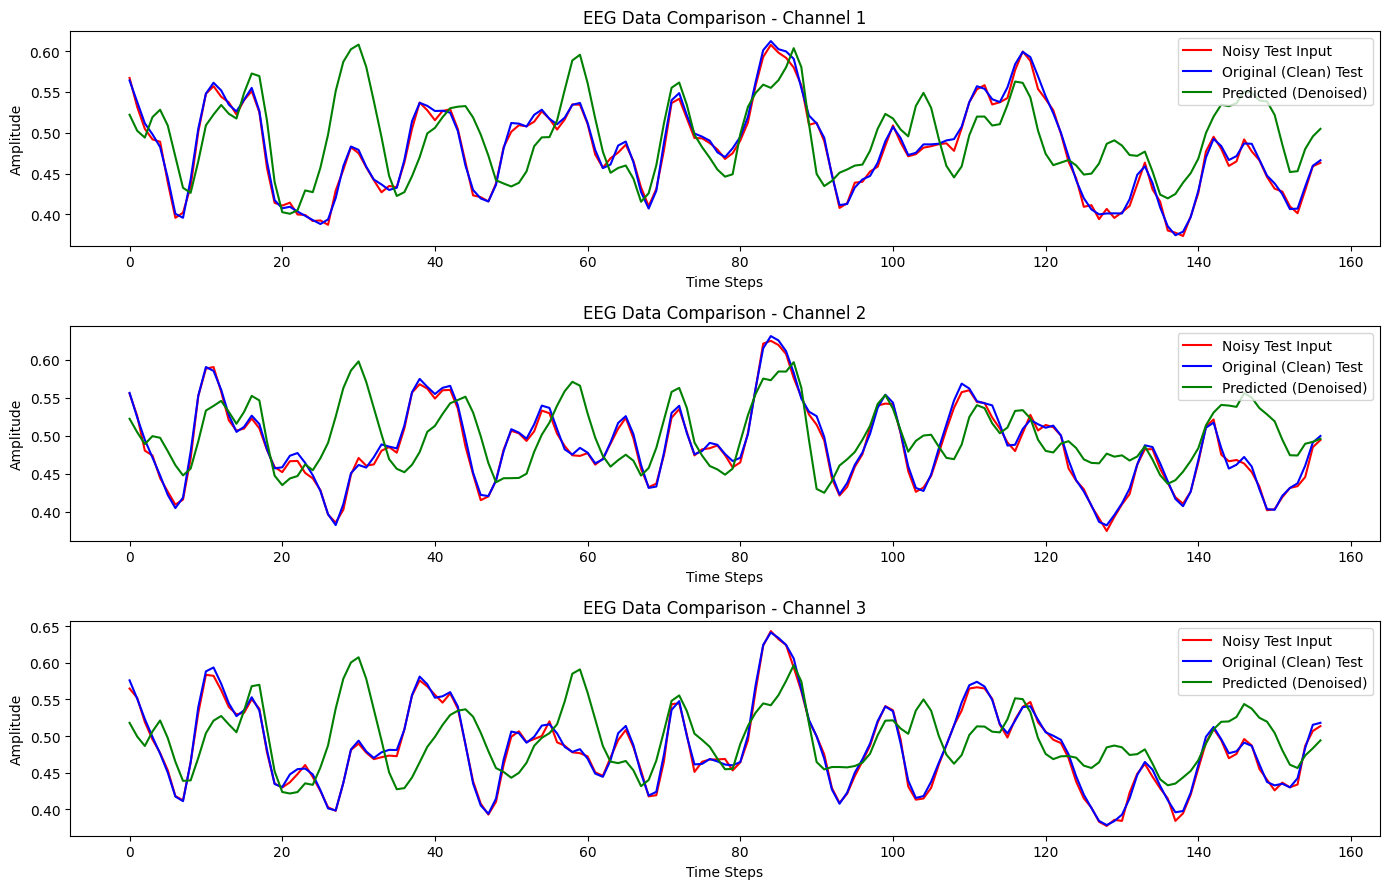

In [77]:
import matplotlib.pyplot as plt

def plot_comparison_eeg(x_test, y_test, predicted_outputs, channel_indices=[0], time_range=None, sample_index=0):
    """
    Plots comparison of EEG data for test input, test ground truth, and predicted outputs.

    Parameters:
    - x_test: numpy array of shape (batch_size, sequence_length, num_features), noisy EEG data used for testing.
    - y_test: numpy array of the same shape, original EEG data (ground truth for testing).
    - predicted_outputs: numpy array of the same shape, model's prediction on x_test.
    - channel_indices: list of integers, indices of the channels to plot.
    - time_range: tuple of (start, end), range of time steps to plot. Defaults to the full range.
    - sample_index: integer, index of the sample from the test set to plot.
    """
    # Define the time range to plot if not specified
    if time_range is None:
        time_range = (0, x_test.shape[1])  # Use the full range of time steps
    
    num_plots = len(channel_indices)
    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3 * num_plots), squeeze=False)
    
    # Iterate over each specified channel index
    for i, channel_idx in enumerate(channel_indices):
        ax = axes[i][0]
        # Plot each dataset; update indexing to reflect the last dimension as channels
        ax.plot(x_test[sample_index, time_range[0]:time_range[1], channel_idx], label='Noisy Test Input', color='red')
        ax.plot(y_test[sample_index, time_range[0]:time_range[1], channel_idx], label='Original (Clean) Test', color='blue')
        ax.plot(predicted_outputs[sample_index, time_range[0]:time_range[1], channel_idx], label='Predicted (Denoised)', color='green')
        
        ax.set_title(f'EEG Data Comparison - Channel {channel_idx + 1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Amplitude')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage of the function
# Assume x_test, y_test, and predicted_outputs are loaded with the correct shapes
plot_comparison_eeg(x_test, y_test, predicted_outputs, channel_indices=[0, 1, 2], time_range=(100, 300), sample_index=0)


In [78]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 257, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 257, 22)   │     23,318 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 257, 22)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 257, 22)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 257, 256)  │      5,888 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 257, 22)   │      5,654 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 257, 22)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 257, 22)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 257, 22)   │     23,318 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 257, 22)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 257, 22)   │          0 │ dropout_6[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 257, 256)  │      5,888 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 257, 22)   │      5,654 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 257, 22)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 257, 22)   │          0 │ dropout_7[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 316,052 (1.21 MB)

 Trainable params: 105,350 (411.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 210,702 (823.06 KB)

To DO:
We plan to jointly train this Transformer Denoiser network with EEGNet using a joint Loss function: Reconstruction loss for Denoiser + BCE loss for classification. 

Training standalone Transformer on reconstruction task is not necessary unless to make sure it's working. Fine tuning model hyperparameters and architecture has to be performed jointly on Transformer(Denoiser) + EEGNet pipeline, with frozen weights for EEGNet. 

Immediate task: Train the EEGNet by running necessary scripts and save the model weights, as they are currently missing. 

Next, import the EEGNet model from python script as a library into the Transformer notebook, instantiate the model, load the weights, and make trainable=False to freeze the weights. 

Then, build the pipeline of Transformer + EEGNet and optimize(train) the Transformer model using the joint loss function. 

Finally, write this as a script.

Note: For Transformer architecture, you can use classical time encoding methods or use learning methods like time2vec with trainable weights

Note: You can either design the Denoiser as an offset producer (have a skip connection from input and subtract it with pre-final output to effectively output the offset requiret to Denoise EEG data. OR view the Denoiser as a signal enhancer that will produce a cleaner version of raw signal with only important features, removing irrelevant details.

**Tasks:**

Build Three types of Autoencoders: CNN, LSTM, Transformers, compare their performance (as a signal reconstruction prpoblem - denoinsing task) and present results in final paper. Continue using the best performing model in building end-to-end training pipeline along with EEGNet.

Note the number of trainable parameters also, in each model!